In [ ]:
# ==== RANDOM FOREST with Recall-First Threshold (choose HIGHEST threshold meeting target) ====
# - Uses explicit numeric/binary columns
# - Cleans column names to safe identifiers
# - 80:20 split with stratify
# - Handles imbalance via class_weight="balanced"
# - Picks the HIGHEST threshold with recall >= TARGET_RECALL (reduces FP flood)
# - Prints metrics at chosen threshold + 95% Wilson CIs + ROC-AUC/PR-AUC
# - Plots top features

import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from difflib import get_close_matches
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, precision_score, recall_score
)
from sklearn.ensemble import RandomForestClassifier


# ========= 1) SETTINGS =========
file_path  = r"C:\Users\Peempol\ML_Autover\Ex1\completeclean.csv"
target_col = "anyflag"

numeric_cols = [
    'age','Q_Flag_BlastsAbn_Lympho','Q_Flag_Blasts','Q_Flag_AbnLympho',
    'Q_Flag_LeftShift','Q_Flag_Atypical_Lympho','Q_Flag_RBC_Agglutination',
    'Q_Flag_TurbidityHGBInterf','Q_Flag_Iron_Deficiency','Q_FlagHGB_Defect',
    'Q_Flag_Fragments','Q_Flag_PLT_Clumps','swbc','srbc','shgb','shct',
    'smcv','smch','smchc','splt','srdw','srdw_1','spdw','smpv','slcr','spct',
    'snrbc','snrbcpercent','sn','sl','smo','seo','sbaso','snper','slper',
    'smoper','seoper','sbaper','sig','sigper','splti','MicroR','MacroR',
    'tnc','ba_n','ba_n_per','wbc_D','tnc_D','NEUT_1','NEUTpercent',
    'LYMP','LYMPper','HFLC','HFLCper','BA_D','BA_D_1','NE_SSC','NE_SFL',
    'NE_FSC','LY_X','LY_Y','LY_Z','MO_X','MO_Y','MO_Z','NE_WX','NE_WY',
    'NE_WZ','LY_WX','LY_WY','LY_WZ','MO_WX','MO_WY','MO_WZ'
]

binary_cols = [
    'sex','WARD','WBC_Abnormal','WBC_Suspect','RBC_Abnormal','RBC_Suspect',
    'PLT_Abnormal','PLT_Suspect','IP_ABN_WBC_Abn_Scattergram',
    'IP_ABN_WBC_Neutropenia','IP_ABN_WBC_Neutrophilia',
    'IP_ABN_WBC_Lymphopenia','IP_ABN_WBC_Lymphocytosis',
    'IP_ABN_WBC_Monocytosis','IP_ABN_WBC_Eosinophilia','IP_ABN_WBC_Basophilia',
    'IP_ABN_WBC_Leukocytopenia','IP_ABN_WBC_Leukocytosis',
    'IP_ABN_WBC_NRBC_Present','IP_ABN_WBC_IG_Present',
    'IP_ABN_RBC_RBC_Abn_Distribution','IP_ABN_RBC_Dimorphic_Population',
    'IP_ABN_RBC_Anisocytosis','IP_ABN_RBC_Microcytosis','IP_ABN_RBC_Macrocytosis',
    'IP_ABN_RBC_Hypochromia','IP_ABN_RBC_Anemia','IP_ABN_RBC_Erythrocytosis',
    'IP_ABN_RBC_RET_Abn_Scattergram','IP_ABN_RBC_Reticulocytosis',
    'IP_ABN_PLT_PLT_Abn_Distribution','IP_ABN_PLT_Thrombocytopenia',
    'IP_ABN_PLT_Thrombocytosis','IP_ABN_PLT_PLT_Abn_Scattergram',
    'IP_SUS_WBC_Blasts_Abn_Lympho','IP_SUS_WBC_Blasts',
    'IP_SUS_WBC_Abn_Lympho','IP_SUS_WBC_Left_Shift',
    'IP_SUS_WBC_Atypical_Lympho','IP_SUS_RBC_RBC_Agglutination',
    'IP_SUS_RBC_Turbidity_HGB_Interf','IP_SUS_RBC_Iron_Deficiency',
    'IP_SUS_RBC_HGB_Defect','IP_SUS_RBC_Fragments','IP_SUS_PLT_PLT_Clumps'
]

test_size      = 0.20
random_seed    = 42
top_k_features = 20

# IMPORTANT: set TARGET_RECALL to 0.95 and rerun; then set to 0.975 and rerun
TARGET_RECALL  = 0.95

# RF hyperparameters (adjust if needed)
n_estimators      = 600
max_depth         = None
min_samples_leaf  = 5
min_samples_split = 10
max_features      = "sqrt"
bootstrap         = True


# ========= 2) HELPERS =========
def clean_colname(col: str) -> str:
    col = (col
           .replace(" NRBC Present", "_NRBC_Present")
           .replace(" IG Present", "_IG_Present")
           .replace(" Dimorphic Population", "_Dimorphic_Population")
           .replace(" Atypical Lympho", "_Atypical_Lympho")
           .replace(" Turbidity_HGB Interf", "_Turbidity_HGB_Interf"))
    col = re.sub(r'[^0-9a-zA-Z_]', '_', col)
    col = re.sub(r'__+', '_', col).strip('_')
    return col

def to_binary(series: pd.Series) -> pd.Series:
    mapping = {
        "1":1,"0":0,"yes":1,"no":0,"true":1,"false":0,"y":1,"n":0,
        "present":1,"absent":0,"pos":1,"neg":0,"positive":1,"negative":0,
        "abnormal":1,"normal":0,"clumps":1,"no_clumps":0
    }
    s = series.astype(str).str.lower().str.strip().map(mapping)
    if s.isna().any():
        num = pd.to_numeric(series, errors="coerce")
        s = s.where(~num.notna(), (num.fillna(0) != 0).astype(int))
    return s.fillna(0).astype(int)

def wilson_ci(k: int, n: int, alpha: float = 0.05):
    """95% Wilson score interval for a binomial proportion."""
    if n <= 0:
        return (float("nan"), float("nan"))
    z = 1.959963984540054  # 95% CI
    p = k / n
    denom = 1 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = (z * math.sqrt((p*(1-p) + (z**2)/(4*n)) / n)) / denom
    return (center - half, center + half)

def approx_halfwidth(p: float, n: int):
    """Approx 95% CI half-width (planning)."""
    if n <= 0:
        return float("nan")
    z = 1.959963984540054
    return z * math.sqrt(p*(1-p)/n)

def metrics_with_cis(y_true: np.ndarray, y_pred: np.ndarray):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    n_pos = tp + fn
    n_neg = tn + fp

    recall = tp / n_pos if n_pos else float("nan")
    spec   = tn / n_neg if n_neg else float("nan")
    ppv    = tp / (tp + fp) if (tp + fp) else float("nan")
    npv    = tn / (tn + fn) if (tn + fn) else float("nan")

    return {
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "n_total": int(len(y_true)), "n_pos": int(n_pos), "n_neg": int(n_neg),
        "recall": recall, "recall_ci": wilson_ci(tp, n_pos),
        "specificity": spec, "specificity_ci": wilson_ci(tn, n_neg),
        "ppv": ppv, "ppv_ci": wilson_ci(tp, tp + fp) if (tp + fp) else (float("nan"), float("nan")),
        "npv": npv, "npv_ci": wilson_ci(tn, tn + fn) if (tn + fn) else (float("nan"), float("nan")),
    }

def pct(x):  # helper for printing
    return 100.0 * x


# ========= 3) LOAD & CLEAN =========
df = pd.read_csv(file_path, low_memory=False)
df.columns = [clean_colname(c) for c in df.columns]

# ========= 4) VALIDATE REQUESTED COLUMNS =========
want_cols = numeric_cols + binary_cols + [target_col]
missing = [c for c in want_cols if c not in df.columns]
if missing:
    print("\n[WARN] Columns not found after cleaning. Adjust lists or cleaner:")
    for m in missing:
        sug = get_close_matches(m, df.columns.tolist(), n=1, cutoff=0.7)
        print(f"  - {m}" + (f"  (closest: {sug[0]})" if sug else ""))

avail_numeric = [c for c in numeric_cols if c in df.columns]
avail_binary  = [c for c in binary_cols  if c in df.columns]

if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found. Available: {df.columns.tolist()}")

# ========= 5) TYPE COERCION =========
for c in avail_numeric:
    df[c] = pd.to_numeric(df[c], errors="coerce")

for c in avail_binary:
    df[c] = to_binary(df[c])

df = df[~df[target_col].isna()].copy()

y = df[target_col]
if not np.issubdtype(y.dtype, np.number):
    y = y.astype("category").cat.codes
y = np.asarray(y)

X = df[avail_numeric + avail_binary].fillna(0)

# Drop constant columns
const_cols = X.columns[X.nunique() <= 1].tolist()
if const_cols:
    X = X.drop(columns=const_cols)

# ========= 6) SPLIT =========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_seed, stratify=y
)

# ========= 7) RANDOM FOREST =========
rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    min_samples_split=min_samples_split,
    max_features=max_features,
    bootstrap=bootstrap,
    n_jobs=-1,
    random_state=random_seed,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

# ========= 8) THRESHOLD TUNING (HIGHEST threshold meeting recall target) =========
if len(np.unique(y_train)) != 2:
    raise ValueError("This script expects a binary target for threshold tuning.")

y_proba = rf.predict_proba(X_test)[:, 1]

thr_candidates = np.unique(np.r_[0.0, np.round(y_proba, 6), 1.0])

rows = []
for thr in thr_candidates:
    y_hat = (y_proba >= thr).astype(int)
    prec = precision_score(y_test, y_hat, zero_division=0)
    rec  = recall_score(y_test, y_hat, zero_division=0)
    fn   = int(((y_test == 1) & (y_hat == 0)).sum())
    fp   = int(((y_test == 0) & (y_hat == 1)).sum())
    rows.append((thr, prec, rec, fn, fp))

thr_df = pd.DataFrame(rows, columns=["threshold","precision","recall","FN","FP"])

meets = thr_df[thr_df["recall"] >= TARGET_RECALL]
if len(meets):
    best_row = meets.sort_values(by=["threshold"], ascending=[False]).iloc[0]
else:
    best_row = thr_df.sort_values(by=["recall","threshold"], ascending=[False, False]).iloc[0]

BEST_THR = float(best_row["threshold"])
print(f"\nChosen threshold = {BEST_THR:.6f} | recall={best_row['recall']:.4f} "
      f"| precision={best_row['precision']:.4f} | FN={best_row['FN']} | FP={best_row['FP']}")

y_pred_thr = (y_proba >= BEST_THR).astype(int)

print("\n=== Report @ chosen threshold (recall-first, highest threshold) ===")
print(classification_report(y_test, y_pred_thr, digits=4))
print("Confusion matrix @ chosen threshold:")
print(confusion_matrix(y_test, y_pred_thr))

# ========= 9) METRICS + 95% Wilson CIs =========
m = metrics_with_cis(y_test, y_pred_thr)

print("\n=== Metrics with 95% Wilson CIs ===")
print(f"Test set: N={m['n_total']} | positives={m['n_pos']} | negatives={m['n_neg']}")
print(f"Recall/Sensitivity = {m['recall']:.4f} (95% CI {m['recall_ci'][0]:.4f}–{m['recall_ci'][1]:.4f})")
print(f"Specificity         = {m['specificity']:.4f} (95% CI {m['specificity_ci'][0]:.4f}–{m['specificity_ci'][1]:.4f})")
print(f"PPV                 = {m['ppv']:.4f} (95% CI {m['ppv_ci'][0]:.4f}–{m['ppv_ci'][1]:.4f})")
print(f"NPV                 = {m['npv']:.4f} (95% CI {m['npv_ci'][0]:.4f}–{m['npv_ci'][1]:.4f})")

# Adequacy: precision depends on #positives
hw_if_95  = approx_halfwidth(0.95,  m["n_pos"])
hw_if_975 = approx_halfwidth(0.975, m["n_pos"])
print("\n=== Recall precision (approx; depends on #positives in test set) ===")
print(f"Approx 95% CI half-width if true recall=0.95  : ±{hw_if_95:.4f}")
print(f"Approx 95% CI half-width if true recall=0.975 : ±{hw_if_975:.4f}")

# ========= 10) ROC-AUC + PR-AUC =========
try:
    roc = roc_auc_score(y_test, y_proba)
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
    order = np.argsort(rec_curve)
    pr_auc = np.trapz(prec_curve[order], rec_curve[order])
    print(f"\nROC-AUC={roc:.4f} | PR-AUC≈{pr_auc:.4f}")
except Exception as e:
    print(f"\n[WARN] Could not compute ROC/PR AUC: {e}")

# ========= 11) FEATURE IMPORTANCE PLOT =========
importances = rf.feature_importances_
imp = (pd.DataFrame({"Feature": X.columns, "Importance": importances})
       .sort_values("Importance", ascending=False)
       .reset_index(drop=True))

print("\nTop features:")
print(imp.head(top_k_features))

plt.figure(figsize=(10, 6))
top = imp.head(top_k_features)[::-1]
plt.barh(top["Feature"], top["Importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_k_features} Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# ========= 12) DEPLOYMENT HINT =========
# probs = rf.predict_proba(X_new)[:, 1]
# preds = (probs >= BEST_THR).astype(int)



Chosen threshold = 0.115203 | recall=0.9752 | precision=0.5674 | FN=97.0 | FP=2906.0

=== Report @ chosen threshold (recall-first, highest threshold) ===
              precision    recall  f1-score   support

         0.0     0.9836    0.6672    0.7951      8733
         1.0     0.5674    0.9752    0.7174      3908

    accuracy                         0.7624     12641
   macro avg     0.7755    0.8212    0.7562     12641
weighted avg     0.8549    0.7624    0.7711     12641

Confusion matrix @ chosen threshold:
[[5827 2906]
 [  97 3811]]

=== Metrics with 95% Wilson CIs ===
Test set: N=12641 | positives=3908 | negatives=8733
Recall/Sensitivity = 0.9752 (95% CI 0.9698–0.9796)
Specificity         = 0.6672 (95% CI 0.6573–0.6770)
PPV                 = 0.5674 (95% CI 0.5555–0.5792)
NPV                 = 0.9836 (95% CI 0.9801–0.9866)

=== Recall precision (approx; depends on #positives in test set) ===
Approx 95% CI half-width if true recall=0.95  : ±0.0068
Approx 95% CI half-width if true

C:\Users\Peempol\AppData\Local\Temp\ipykernel_18660\603331451.py:265: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc = np.trapz(prec_curve[order], rec_curve[order])


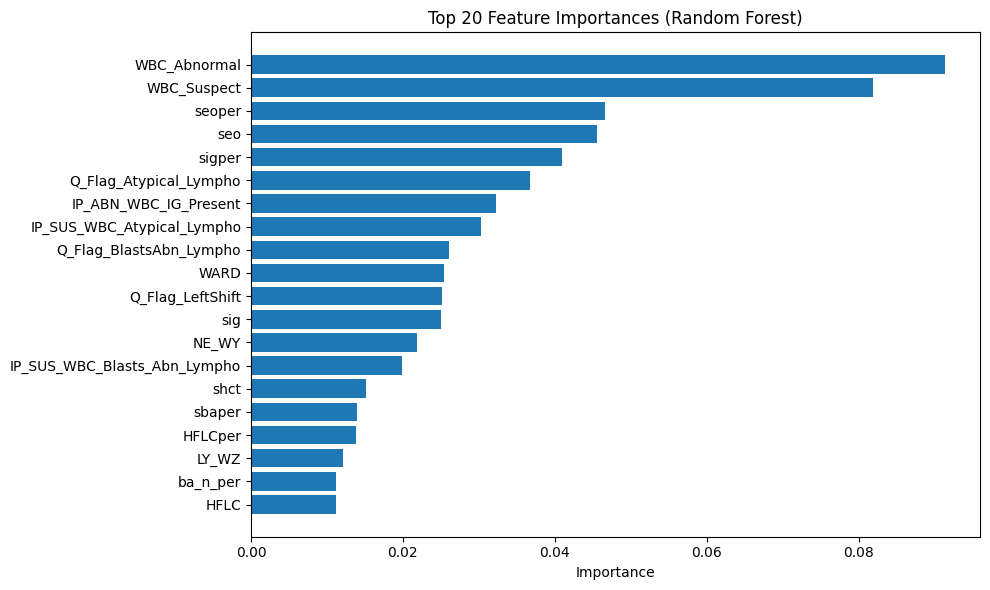

In [10]:
# ==== RANDOM FOREST with Recall-First Threshold (choose HIGHEST threshold meeting target) ====
# - Uses explicit numeric/binary columns
# - Cleans column names to safe identifiers
# - 80:20 split with stratify
# - Handles imbalance via class_weight="balanced"
# - Picks the HIGHEST threshold with recall >= TARGET_RECALL (reduces FP flood)
# - Prints metrics at chosen threshold + 95% Wilson CIs + ROC-AUC/PR-AUC
# - Plots top features

import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from difflib import get_close_matches
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, precision_score, recall_score
)
from sklearn.ensemble import RandomForestClassifier


# ========= 1) SETTINGS =========
file_path  = r"C:\Users\Peempol\ML_Autover\Ex1\completeclean.csv"
target_col = "anyflag"

numeric_cols = [
    'age','Q_Flag_BlastsAbn_Lympho','Q_Flag_Blasts','Q_Flag_AbnLympho',
    'Q_Flag_LeftShift','Q_Flag_Atypical_Lympho','Q_Flag_RBC_Agglutination',
    'Q_Flag_TurbidityHGBInterf','Q_Flag_Iron_Deficiency','Q_FlagHGB_Defect',
    'Q_Flag_Fragments','Q_Flag_PLT_Clumps','swbc','srbc','shgb','shct',
    'smcv','smch','smchc','splt','srdw','srdw_1','spdw','smpv','slcr','spct',
    'snrbc','snrbcpercent','sn','sl','smo','seo','sbaso','snper','slper',
    'smoper','seoper','sbaper','sig','sigper','splti','MicroR','MacroR',
    'tnc','ba_n','ba_n_per','wbc_D','tnc_D','NEUT_1','NEUTpercent',
    'LYMP','LYMPper','HFLC','HFLCper','BA_D','BA_D_1','NE_SSC','NE_SFL',
    'NE_FSC','LY_X','LY_Y','LY_Z','MO_X','MO_Y','MO_Z','NE_WX','NE_WY',
    'NE_WZ','LY_WX','LY_WY','LY_WZ','MO_WX','MO_WY','MO_WZ'
]

binary_cols = [
    'sex','WARD','WBC_Abnormal','WBC_Suspect','RBC_Abnormal','RBC_Suspect',
    'PLT_Abnormal','PLT_Suspect','IP_ABN_WBC_Abn_Scattergram',
    'IP_ABN_WBC_Neutropenia','IP_ABN_WBC_Neutrophilia',
    'IP_ABN_WBC_Lymphopenia','IP_ABN_WBC_Lymphocytosis',
    'IP_ABN_WBC_Monocytosis','IP_ABN_WBC_Eosinophilia','IP_ABN_WBC_Basophilia',
    'IP_ABN_WBC_Leukocytopenia','IP_ABN_WBC_Leukocytosis',
    'IP_ABN_WBC_NRBC_Present','IP_ABN_WBC_IG_Present',
    'IP_ABN_RBC_RBC_Abn_Distribution','IP_ABN_RBC_Dimorphic_Population',
    'IP_ABN_RBC_Anisocytosis','IP_ABN_RBC_Microcytosis','IP_ABN_RBC_Macrocytosis',
    'IP_ABN_RBC_Hypochromia','IP_ABN_RBC_Anemia','IP_ABN_RBC_Erythrocytosis',
    'IP_ABN_RBC_RET_Abn_Scattergram','IP_ABN_RBC_Reticulocytosis',
    'IP_ABN_PLT_PLT_Abn_Distribution','IP_ABN_PLT_Thrombocytopenia',
    'IP_ABN_PLT_Thrombocytosis','IP_ABN_PLT_PLT_Abn_Scattergram',
    'IP_SUS_WBC_Blasts_Abn_Lympho','IP_SUS_WBC_Blasts',
    'IP_SUS_WBC_Abn_Lympho','IP_SUS_WBC_Left_Shift',
    'IP_SUS_WBC_Atypical_Lympho','IP_SUS_RBC_RBC_Agglutination',
    'IP_SUS_RBC_Turbidity_HGB_Interf','IP_SUS_RBC_Iron_Deficiency',
    'IP_SUS_RBC_HGB_Defect','IP_SUS_RBC_Fragments','IP_SUS_PLT_PLT_Clumps'
]

test_size      = 0.20
random_seed    = 42
top_k_features = 20

# IMPORTANT: set TARGET_RECALL to 0.95 and rerun; then set to 0.975 and rerun
TARGET_RECALL  = 0.975

# RF hyperparameters (adjust if needed)
n_estimators      = 600
max_depth         = None
min_samples_leaf  = 5
min_samples_split = 10
max_features      = "sqrt"
bootstrap         = True


# ========= 2) HELPERS =========
def clean_colname(col: str) -> str:
    col = (col
           .replace(" NRBC Present", "_NRBC_Present")
           .replace(" IG Present", "_IG_Present")
           .replace(" Dimorphic Population", "_Dimorphic_Population")
           .replace(" Atypical Lympho", "_Atypical_Lympho")
           .replace(" Turbidity_HGB Interf", "_Turbidity_HGB_Interf"))
    col = re.sub(r'[^0-9a-zA-Z_]', '_', col)
    col = re.sub(r'__+', '_', col).strip('_')
    return col

def to_binary(series: pd.Series) -> pd.Series:
    mapping = {
        "1":1,"0":0,"yes":1,"no":0,"true":1,"false":0,"y":1,"n":0,
        "present":1,"absent":0,"pos":1,"neg":0,"positive":1,"negative":0,
        "abnormal":1,"normal":0,"clumps":1,"no_clumps":0
    }
    s = series.astype(str).str.lower().str.strip().map(mapping)
    if s.isna().any():
        num = pd.to_numeric(series, errors="coerce")
        s = s.where(~num.notna(), (num.fillna(0) != 0).astype(int))
    return s.fillna(0).astype(int)

def wilson_ci(k: int, n: int, alpha: float = 0.05):
    """95% Wilson score interval for a binomial proportion."""
    if n <= 0:
        return (float("nan"), float("nan"))
    z = 1.959963984540054  # 95% CI
    p = k / n
    denom = 1 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = (z * math.sqrt((p*(1-p) + (z**2)/(4*n)) / n)) / denom
    return (center - half, center + half)

def approx_halfwidth(p: float, n: int):
    """Approx 95% CI half-width (planning)."""
    if n <= 0:
        return float("nan")
    z = 1.959963984540054
    return z * math.sqrt(p*(1-p)/n)

def metrics_with_cis(y_true: np.ndarray, y_pred: np.ndarray):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    n_pos = tp + fn
    n_neg = tn + fp

    recall = tp / n_pos if n_pos else float("nan")
    spec   = tn / n_neg if n_neg else float("nan")
    ppv    = tp / (tp + fp) if (tp + fp) else float("nan")
    npv    = tn / (tn + fn) if (tn + fn) else float("nan")

    return {
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "n_total": int(len(y_true)), "n_pos": int(n_pos), "n_neg": int(n_neg),
        "recall": recall, "recall_ci": wilson_ci(tp, n_pos),
        "specificity": spec, "specificity_ci": wilson_ci(tn, n_neg),
        "ppv": ppv, "ppv_ci": wilson_ci(tp, tp + fp) if (tp + fp) else (float("nan"), float("nan")),
        "npv": npv, "npv_ci": wilson_ci(tn, tn + fn) if (tn + fn) else (float("nan"), float("nan")),
    }

def pct(x):  # helper for printing
    return 100.0 * x


# ========= 3) LOAD & CLEAN =========
df = pd.read_csv(file_path, low_memory=False)
df.columns = [clean_colname(c) for c in df.columns]

# ========= 4) VALIDATE REQUESTED COLUMNS =========
want_cols = numeric_cols + binary_cols + [target_col]
missing = [c for c in want_cols if c not in df.columns]
if missing:
    print("\n[WARN] Columns not found after cleaning. Adjust lists or cleaner:")
    for m in missing:
        sug = get_close_matches(m, df.columns.tolist(), n=1, cutoff=0.7)
        print(f"  - {m}" + (f"  (closest: {sug[0]})" if sug else ""))

avail_numeric = [c for c in numeric_cols if c in df.columns]
avail_binary  = [c for c in binary_cols  if c in df.columns]

if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found. Available: {df.columns.tolist()}")

# ========= 5) TYPE COERCION =========
for c in avail_numeric:
    df[c] = pd.to_numeric(df[c], errors="coerce")

for c in avail_binary:
    df[c] = to_binary(df[c])

df = df[~df[target_col].isna()].copy()

y = df[target_col]
if not np.issubdtype(y.dtype, np.number):
    y = y.astype("category").cat.codes
y = np.asarray(y)

X = df[avail_numeric + avail_binary].fillna(0)

# Drop constant columns
const_cols = X.columns[X.nunique() <= 1].tolist()
if const_cols:
    X = X.drop(columns=const_cols)

# ========= 6) SPLIT =========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_seed, stratify=y
)

# ========= 7) RANDOM FOREST =========
rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    min_samples_split=min_samples_split,
    max_features=max_features,
    bootstrap=bootstrap,
    n_jobs=-1,
    random_state=random_seed,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

# ========= 8) THRESHOLD TUNING (HIGHEST threshold meeting recall target) =========
if len(np.unique(y_train)) != 2:
    raise ValueError("This script expects a binary target for threshold tuning.")

y_proba = rf.predict_proba(X_test)[:, 1]

thr_candidates = np.unique(np.r_[0.0, np.round(y_proba, 6), 1.0])

rows = []
for thr in thr_candidates:
    y_hat = (y_proba >= thr).astype(int)
    prec = precision_score(y_test, y_hat, zero_division=0)
    rec  = recall_score(y_test, y_hat, zero_division=0)
    fn   = int(((y_test == 1) & (y_hat == 0)).sum())
    fp   = int(((y_test == 0) & (y_hat == 1)).sum())
    rows.append((thr, prec, rec, fn, fp))

thr_df = pd.DataFrame(rows, columns=["threshold","precision","recall","FN","FP"])

meets = thr_df[thr_df["recall"] >= TARGET_RECALL]
if len(meets):
    best_row = meets.sort_values(by=["threshold"], ascending=[False]).iloc[0]
else:
    best_row = thr_df.sort_values(by=["recall","threshold"], ascending=[False, False]).iloc[0]

BEST_THR = float(best_row["threshold"])
print(f"\nChosen threshold = {BEST_THR:.6f} | recall={best_row['recall']:.4f} "
      f"| precision={best_row['precision']:.4f} | FN={best_row['FN']} | FP={best_row['FP']}")

y_pred_thr = (y_proba >= BEST_THR).astype(int)

print("\n=== Report @ chosen threshold (recall-first, highest threshold) ===")
print(classification_report(y_test, y_pred_thr, digits=4))
print("Confusion matrix @ chosen threshold:")
print(confusion_matrix(y_test, y_pred_thr))

# ========= 9) METRICS + 95% Wilson CIs =========
m = metrics_with_cis(y_test, y_pred_thr)

print("\n=== Metrics with 95% Wilson CIs ===")
print(f"Test set: N={m['n_total']} | positives={m['n_pos']} | negatives={m['n_neg']}")
print(f"Recall/Sensitivity = {m['recall']:.4f} (95% CI {m['recall_ci'][0]:.4f}–{m['recall_ci'][1]:.4f})")
print(f"Specificity         = {m['specificity']:.4f} (95% CI {m['specificity_ci'][0]:.4f}–{m['specificity_ci'][1]:.4f})")
print(f"PPV                 = {m['ppv']:.4f} (95% CI {m['ppv_ci'][0]:.4f}–{m['ppv_ci'][1]:.4f})")
print(f"NPV                 = {m['npv']:.4f} (95% CI {m['npv_ci'][0]:.4f}–{m['npv_ci'][1]:.4f})")

# Adequacy: precision depends on #positives
hw_if_95  = approx_halfwidth(0.95,  m["n_pos"])
hw_if_975 = approx_halfwidth(0.975, m["n_pos"])
print("\n=== Recall precision (approx; depends on #positives in test set) ===")
print(f"Approx 95% CI half-width if true recall=0.95  : ±{hw_if_95:.4f}")
print(f"Approx 95% CI half-width if true recall=0.975 : ±{hw_if_975:.4f}")

# ========= 10) ROC-AUC + PR-AUC =========
try:
    roc = roc_auc_score(y_test, y_proba)
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
    order = np.argsort(rec_curve)
    pr_auc = np.trapz(prec_curve[order], rec_curve[order])
    print(f"\nROC-AUC={roc:.4f} | PR-AUC≈{pr_auc:.4f}")
except Exception as e:
    print(f"\n[WARN] Could not compute ROC/PR AUC: {e}")

# ========= 11) FEATURE IMPORTANCE PLOT =========
importances = rf.feature_importances_
imp = (pd.DataFrame({"Feature": X.columns, "Importance": importances})
       .sort_values("Importance", ascending=False)
       .reset_index(drop=True))

print("\nTop features:")
print(imp.head(top_k_features))

plt.figure(figsize=(10, 6))
top = imp.head(top_k_features)[::-1]
plt.barh(top["Feature"], top["Importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_k_features} Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# ========= 12) DEPLOYMENT HINT =========
# probs = rf.predict_proba(X_new)[:, 1]
# preds = (probs >= BEST_THR).astype(int)


In [ ]:
# ==== DECISION TREE with Recall-First Threshold (choose HIGHEST threshold meeting target) ====
# - Uses explicit numeric/binary columns
# - Cleans column names to safe identifiers
# - 80:20 split with stratify
# - Handles imbalance via class_weight="balanced"
# - Picks the HIGHEST threshold with recall >= TARGET_RECALL (reduces FP flood)
# - Prints metrics at chosen threshold + 95% Wilson CIs
# - Plots top features and top tree levels

import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from difflib import get_close_matches
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, precision_score, recall_score
)
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# ========= 1) SETTINGS =========
file_path  = r"C:\Users\Peempol\ML_Autover\Ex1\completeclean.csv"
target_col = "anyflag"

numeric_cols = [
    'age','Q_Flag_BlastsAbn_Lympho','Q_Flag_Blasts','Q_Flag_AbnLympho',
    'Q_Flag_LeftShift','Q_Flag_Atypical_Lympho','Q_Flag_RBC_Agglutination',
    'Q_Flag_TurbidityHGBInterf','Q_Flag_Iron_Deficiency','Q_FlagHGB_Defect',
    'Q_Flag_Fragments','Q_Flag_PLT_Clumps','swbc','srbc','shgb','shct',
    'smcv','smch','smchc','splt','srdw','srdw_1','spdw','smpv','slcr','spct',
    'snrbc','snrbcpercent','sn','sl','smo','seo','sbaso','snper','slper',
    'smoper','seoper','sbaper','sig','sigper','splti','MicroR','MacroR',
    'tnc','ba_n','ba_n_per','wbc_D','tnc_D','NEUT_1','NEUTpercent',
    'LYMP','LYMPper','HFLC','HFLCper','BA_D','BA_D_1','NE_SSC','NE_SFL',
    'NE_FSC','LY_X','LY_Y','LY_Z','MO_X','MO_Y','MO_Z','NE_WX','NE_WY',
    'NE_WZ','LY_WX','LY_WY','LY_WZ','MO_WX','MO_WY','MO_WZ'
]

binary_cols = [
    'sex','WARD','WBC_Abnormal','WBC_Suspect','RBC_Abnormal','RBC_Suspect',
    'PLT_Abnormal','PLT_Suspect','IP_ABN_WBC_Abn_Scattergram',
    'IP_ABN_WBC_Neutropenia','IP_ABN_WBC_Neutrophilia',
    'IP_ABN_WBC_Lymphopenia','IP_ABN_WBC_Lymphocytosis',
    'IP_ABN_WBC_Monocytosis','IP_ABN_WBC_Eosinophilia','IP_ABN_WBC_Basophilia',
    'IP_ABN_WBC_Leukocytopenia','IP_ABN_WBC_Leukocytosis',
    'IP_ABN_WBC_NRBC_Present','IP_ABN_WBC_IG_Present',
    'IP_ABN_RBC_RBC_Abn_Distribution','IP_ABN_RBC_Dimorphic_Population',
    'IP_ABN_RBC_Anisocytosis','IP_ABN_RBC_Microcytosis','IP_ABN_RBC_Macrocytosis',
    'IP_ABN_RBC_Hypochromia','IP_ABN_RBC_Anemia','IP_ABN_RBC_Erythrocytosis',
    'IP_ABN_RBC_RET_Abn_Scattergram','IP_ABN_RBC_Reticulocytosis',
    'IP_ABN_PLT_PLT_Abn_Distribution','IP_ABN_PLT_Thrombocytopenia',
    'IP_ABN_PLT_Thrombocytosis','IP_ABN_PLT_PLT_Abn_Scattergram',
    'IP_SUS_WBC_Blasts_Abn_Lympho','IP_SUS_WBC_Blasts',
    'IP_SUS_WBC_Abn_Lympho','IP_SUS_WBC_Left_Shift',
    'IP_SUS_WBC_Atypical_Lympho','IP_SUS_RBC_RBC_Agglutination',
    'IP_SUS_RBC_Turbidity_HGB_Interf','IP_SUS_RBC_Iron_Deficiency',
    'IP_SUS_RBC_HGB_Defect','IP_SUS_RBC_Fragments','IP_SUS_PLT_PLT_Clumps'
]

test_size      = 0.20
random_seed    = 42
top_k_features = 20
TARGET_RECALL  = 0.95   # rerun with 0.975 for the 97.5% operating point

# Tree complexity controls (tune as needed)
criterion         = "gini"   # or "entropy" / "log_loss"
max_depth         = 10
min_samples_split = 20
min_samples_leaf  = 10
ccp_alpha         = 0.0

# ========= 2) HELPERS =========
def clean_colname(col: str) -> str:
    col = (col
           .replace(" NRBC Present", "_NRBC_Present")
           .replace(" IG Present", "_IG_Present")
           .replace(" Dimorphic Population", "_Dimorphic_Population")
           .replace(" Atypical Lympho", "_Atypical_Lympho")
           .replace(" Turbidity_HGB Interf", "_Turbidity_HGB_Interf"))
    col = re.sub(r'[^0-9a-zA-Z_]', '_', col)
    col = re.sub(r'__+', '_', col).strip('_')
    return col

def to_binary(series: pd.Series) -> pd.Series:
    mapping = {
        "1":1,"0":0,"yes":1,"no":0,"true":1,"false":0,"y":1,"n":0,
        "present":1,"absent":0,"pos":1,"neg":0,"positive":1,"negative":0,
        "abnormal":1,"normal":0,"clumps":1,"no_clumps":0
    }
    s = series.astype(str).str.lower().str.strip().map(mapping)
    if s.isna().any():
        num = pd.to_numeric(series, errors="coerce")
        s = s.where(~num.notna(), (num.fillna(0) != 0).astype(int))
    return s.fillna(0).astype(int)

def wilson_ci(k: int, n: int, alpha: float = 0.05):
    """95% Wilson score interval for a binomial proportion."""
    if n <= 0:
        return (float("nan"), float("nan"))
    z = 1.959963984540054
    p = k / n
    denom = 1 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = (z * math.sqrt((p*(1-p) + (z**2)/(4*n)) / n)) / denom
    return (center - half, center + half)

def metrics_with_cis(y_true: np.ndarray, y_pred: np.ndarray):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    n_pos = tp + fn
    n_neg = tn + fp

    recall = tp / n_pos if n_pos else float("nan")
    spec   = tn / n_neg if n_neg else float("nan")
    ppv    = tp / (tp + fp) if (tp + fp) else float("nan")
    npv    = tn / (tn + fn) if (tn + fn) else float("nan")

    return {
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "n_total": int(len(y_true)), "n_pos": int(n_pos), "n_neg": int(n_neg),
        "recall": recall, "recall_ci": wilson_ci(tp, n_pos),
        "specificity": spec, "specificity_ci": wilson_ci(tn, n_neg),
        "ppv": ppv, "ppv_ci": wilson_ci(tp, tp + fp) if (tp + fp) else (float("nan"), float("nan")),
        "npv": npv, "npv_ci": wilson_ci(tn, tn + fn) if (tn + fn) else (float("nan"), float("nan")),
    }

def pct(x):
    return 100.0 * x

# ========= 3) LOAD & CLEAN COLUMN NAMES =========
df = pd.read_csv(file_path, low_memory=False)
df.columns = [clean_colname(c) for c in df.columns]

# ========= 4) VALIDATE REQUESTED COLUMNS =========
want_cols = numeric_cols + binary_cols + [target_col]
missing = [c for c in want_cols if c not in df.columns]
if missing:
    print("\n[WARN] Columns not found after cleaning. Adjust lists or cleaner:")
    for m in missing:
        sug = get_close_matches(m, df.columns.tolist(), n=1, cutoff=0.7)
        print(f"  - {m}" + (f"  (closest: {sug[0]})" if sug else ""))

avail_numeric = [c for c in numeric_cols if c in df.columns]
avail_binary  = [c for c in binary_cols  if c in df.columns]

if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found. Available: {df.columns.tolist()}")

# ========= 5) TYPE COERCION =========
for c in avail_numeric:
    df[c] = pd.to_numeric(df[c], errors="coerce")

for c in avail_binary:
    df[c] = to_binary(df[c])

df = df[~df[target_col].isna()].copy()

y = df[target_col]
if not np.issubdtype(y.dtype, np.number):
    y = y.astype("category").cat.codes
y = np.asarray(y)

X = df[avail_numeric + avail_binary].fillna(0)

const_cols = X.columns[X.nunique() <= 1].tolist()
if const_cols:
    X = X.drop(columns=const_cols)

# ========= 6) SPLIT =========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_seed, stratify=y
)

# ========= 7) DECISION TREE =========
dt = DecisionTreeClassifier(
    criterion=criterion,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    class_weight="balanced",
    random_state=random_seed,
    ccp_alpha=ccp_alpha
)
dt.fit(X_train, y_train)

# ========= 8) THRESHOLD TUNING (HIGHEST threshold meeting recall target) =========
if len(np.unique(y_train)) != 2:
    raise ValueError("This script expects a binary target for threshold tuning.")

y_proba = dt.predict_proba(X_test)[:, 1]
thr_candidates = np.unique(np.r_[0.0, np.round(y_proba, 6), 1.0])

rows = []
for thr in thr_candidates:
    y_hat = (y_proba >= thr).astype(int)
    prec = precision_score(y_test, y_hat, zero_division=0)
    rec  = recall_score(y_test, y_hat, zero_division=0)
    fn   = int(((y_test == 1) & (y_hat == 0)).sum())
    fp   = int(((y_test == 0) & (y_hat == 1)).sum())
    rows.append((thr, prec, rec, fn, fp))

thr_df = pd.DataFrame(rows, columns=["threshold","precision","recall","FN","FP"])

meets = thr_df[thr_df["recall"] >= TARGET_RECALL]
if len(meets):
    best_row = meets.sort_values(by=["threshold"], ascending=[False]).iloc[0]
else:
    best_row = thr_df.sort_values(by=["recall","threshold"], ascending=[False, False]).iloc[0]

BEST_THR = float(best_row["threshold"])
print(f"\nChosen threshold = {BEST_THR:.6f} | recall={best_row['recall']:.4f} "
      f"| precision={best_row['precision']:.4f} | FN={best_row['FN']} | FP={best_row['FP']}")

y_pred_thr = (y_proba >= BEST_THR).astype(int)

print("\n=== Report @ chosen threshold (recall-first, highest threshold) ===")
print(classification_report(y_test, y_pred_thr, digits=4))
print("Confusion matrix @ chosen threshold:")
print(confusion_matrix(y_test, y_pred_thr))

# ========= 9) METRICS + 95% Wilson CIs =========
m = metrics_with_cis(y_test, y_pred_thr)

print("\n=== Metrics with 95% Wilson CIs ===")
print(f"Test set: N={m['n_total']} | positives={m['n_pos']} | negatives={m['n_neg']}")
print(f"Recall/Sensitivity = {m['recall']:.4f} (95% CI {m['recall_ci'][0]:.4f}–{m['recall_ci'][1]:.4f})")
print(f"Specificity         = {m['specificity']:.4f} (95% CI {m['specificity_ci'][0]:.4f}–{m['specificity_ci'][1]:.4f})")
print(f"PPV                 = {m['ppv']:.4f} (95% CI {m['ppv_ci'][0]:.4f}–{m['ppv_ci'][1]:.4f})")
print(f"NPV                 = {m['npv']:.4f} (95% CI {m['npv_ci'][0]:.4f}–{m['npv_ci'][1]:.4f})")

# ========= 10) ROC-AUC + PR-AUC =========
try:
    roc = roc_auc_score(y_test, y_proba)
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
    order = np.argsort(rec_curve)
    pr_auc = np.trapz(prec_curve[order], rec_curve[order])
    print(f"\nROC-AUC={roc:.4f} | PR-AUC≈{pr_auc:.4f}")
except Exception as e:
    print(f"\n[WARN] Could not compute ROC/PR AUC: {e}")

# ========= 11) TOP FEATURES =========
importances = dt.feature_importances_
imp = (pd.DataFrame({"Feature": X.columns, "Importance": importances})
       .sort_values("Importance", ascending=False)
       .reset_index(drop=True))

print("\nTop features:")
print(imp.head(top_k_features))

plt.figure(figsize=(10, 6))
top = imp.head(top_k_features)[::-1]
plt.barh(top["Feature"], top["Importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_k_features} Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()

# ========= 12) TREE SUMMARY (TOP LEVELS) =========
print("\n=== Tree (text summary, top levels) ===")
print(export_text(dt, feature_names=list(X.columns), max_depth=3))

plt.figure(figsize=(18, 10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["0", "1"],
    filled=True, rounded=True, max_depth=3, fontsize=8
)
plt.title("Decision Tree (top levels)")
plt.show()

# ========= 13) DEPLOYMENT HINT =========
# probs = dt.predict_proba(X_new)[:, 1]
# preds = (probs >= BEST_THR).astype(int)



Chosen threshold = 0.065267 | recall=0.9816 | precision=0.4228 | FN=72.0 | FP=5237.0

=== Report @ chosen threshold (recall-first, highest threshold) ===
              precision    recall  f1-score   support

         0.0     0.9798    0.4003    0.5684      8733
         1.0     0.4228    0.9816    0.5910      3908

    accuracy                         0.5800     12641
   macro avg     0.7013    0.6909    0.5797     12641
weighted avg     0.8076    0.5800    0.5754     12641

Confusion matrix @ chosen threshold:
[[3496 5237]
 [  72 3836]]

=== Metrics with 95% Wilson CIs ===
Test set: N=12641 | positives=3908 | negatives=8733
Recall/Sensitivity = 0.9816 (95% CI 0.9769–0.9853)
Specificity         = 0.4003 (95% CI 0.3901–0.4106)
PPV                 = 0.4228 (95% CI 0.4127–0.4330)
NPV                 = 0.9798 (95% CI 0.9747–0.9839)

ROC-AUC=0.9381 | PR-AUC≈0.8921

Top features:
              Feature  Importance
0        WBC_Abnormal    0.431494
1         WBC_Suspect    0.192373
2        

C:\Users\Peempol\AppData\Local\Temp\ipykernel_18660\707520424.py:240: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc = np.trapz(prec_curve[order], rec_curve[order])


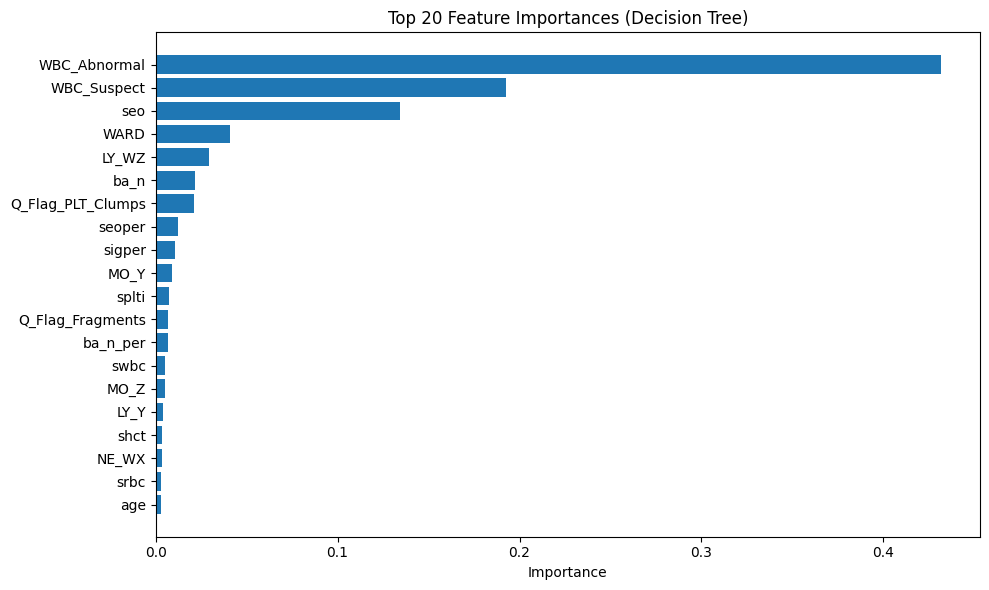


=== Tree (text summary, top levels) ===
|--- WBC_Abnormal <= 0.50
|   |--- WBC_Suspect <= 0.50
|   |   |--- seo <= 0.00
|   |   |   |--- class: 1.0
|   |   |--- seo >  0.00
|   |   |   |--- WARD <= 0.50
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- WARD >  0.50
|   |   |   |   |--- truncated branch of depth 7
|   |--- WBC_Suspect >  0.50
|   |   |--- LYMP <= 3.71
|   |   |   |--- seo <= 0.02
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- seo >  0.02
|   |   |   |   |--- truncated branch of depth 7
|   |   |--- LYMP >  3.71
|   |   |   |--- age <= 6.02
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- age >  6.02
|   |   |   |   |--- truncated branch of depth 7
|--- WBC_Abnormal >  0.50
|   |--- WBC_Suspect <= 0.50
|   |   |--- sigper <= 2.95
|   |   |   |--- seoper <= 0.05
|   |   |   |   |--- class: 1.0
|   |   |   |--- seoper >  0.05
|   |   |   |   |--- truncated branch of depth 7
|   |   |--- sigper >  2.95
|   |   |   |--- si

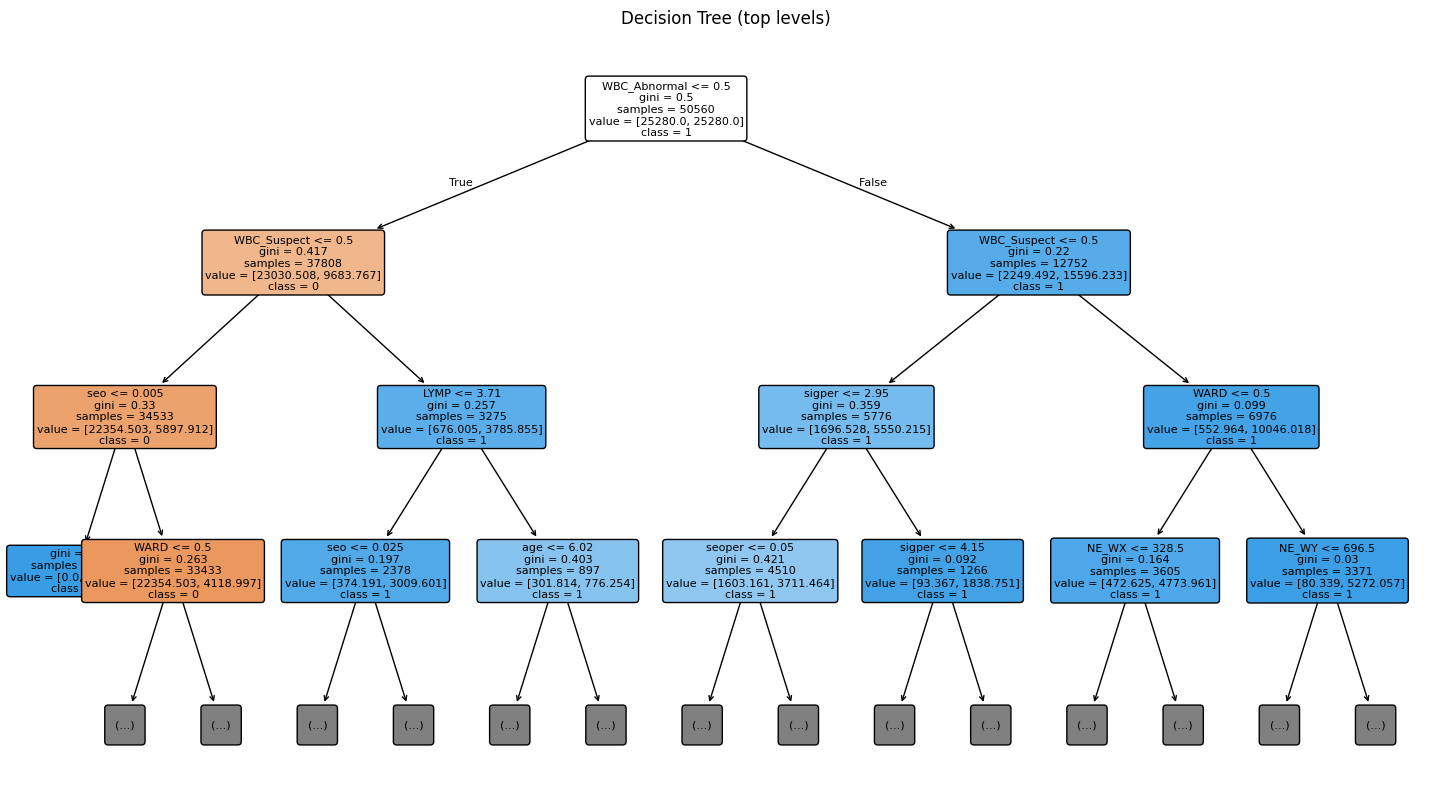

In [15]:
# ==== DECISION TREE with Recall-First Threshold (choose HIGHEST threshold meeting target) ====
# - Uses explicit numeric/binary columns
# - Cleans column names to safe identifiers
# - 80:20 split with stratify
# - Handles imbalance via class_weight="balanced"
# - Picks the HIGHEST threshold with recall >= TARGET_RECALL (reduces FP flood)
# - Prints metrics at chosen threshold + 95% Wilson CIs
# - Plots top features and top tree levels

import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from difflib import get_close_matches
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, precision_score, recall_score
)
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# ========= 1) SETTINGS =========
file_path  = r"C:\Users\Peempol\ML_Autover\Ex1\completeclean.csv"
target_col = "anyflag"

numeric_cols = [
    'age','Q_Flag_BlastsAbn_Lympho','Q_Flag_Blasts','Q_Flag_AbnLympho',
    'Q_Flag_LeftShift','Q_Flag_Atypical_Lympho','Q_Flag_RBC_Agglutination',
    'Q_Flag_TurbidityHGBInterf','Q_Flag_Iron_Deficiency','Q_FlagHGB_Defect',
    'Q_Flag_Fragments','Q_Flag_PLT_Clumps','swbc','srbc','shgb','shct',
    'smcv','smch','smchc','splt','srdw','srdw_1','spdw','smpv','slcr','spct',
    'snrbc','snrbcpercent','sn','sl','smo','seo','sbaso','snper','slper',
    'smoper','seoper','sbaper','sig','sigper','splti','MicroR','MacroR',
    'tnc','ba_n','ba_n_per','wbc_D','tnc_D','NEUT_1','NEUTpercent',
    'LYMP','LYMPper','HFLC','HFLCper','BA_D','BA_D_1','NE_SSC','NE_SFL',
    'NE_FSC','LY_X','LY_Y','LY_Z','MO_X','MO_Y','MO_Z','NE_WX','NE_WY',
    'NE_WZ','LY_WX','LY_WY','LY_WZ','MO_WX','MO_WY','MO_WZ'
]

binary_cols = [
    'sex','WARD','WBC_Abnormal','WBC_Suspect','RBC_Abnormal','RBC_Suspect',
    'PLT_Abnormal','PLT_Suspect','IP_ABN_WBC_Abn_Scattergram',
    'IP_ABN_WBC_Neutropenia','IP_ABN_WBC_Neutrophilia',
    'IP_ABN_WBC_Lymphopenia','IP_ABN_WBC_Lymphocytosis',
    'IP_ABN_WBC_Monocytosis','IP_ABN_WBC_Eosinophilia','IP_ABN_WBC_Basophilia',
    'IP_ABN_WBC_Leukocytopenia','IP_ABN_WBC_Leukocytosis',
    'IP_ABN_WBC_NRBC_Present','IP_ABN_WBC_IG_Present',
    'IP_ABN_RBC_RBC_Abn_Distribution','IP_ABN_RBC_Dimorphic_Population',
    'IP_ABN_RBC_Anisocytosis','IP_ABN_RBC_Microcytosis','IP_ABN_RBC_Macrocytosis',
    'IP_ABN_RBC_Hypochromia','IP_ABN_RBC_Anemia','IP_ABN_RBC_Erythrocytosis',
    'IP_ABN_RBC_RET_Abn_Scattergram','IP_ABN_RBC_Reticulocytosis',
    'IP_ABN_PLT_PLT_Abn_Distribution','IP_ABN_PLT_Thrombocytopenia',
    'IP_ABN_PLT_Thrombocytosis','IP_ABN_PLT_PLT_Abn_Scattergram',
    'IP_SUS_WBC_Blasts_Abn_Lympho','IP_SUS_WBC_Blasts',
    'IP_SUS_WBC_Abn_Lympho','IP_SUS_WBC_Left_Shift',
    'IP_SUS_WBC_Atypical_Lympho','IP_SUS_RBC_RBC_Agglutination',
    'IP_SUS_RBC_Turbidity_HGB_Interf','IP_SUS_RBC_Iron_Deficiency',
    'IP_SUS_RBC_HGB_Defect','IP_SUS_RBC_Fragments','IP_SUS_PLT_PLT_Clumps'
]

test_size      = 0.20
random_seed    = 42
top_k_features = 20
TARGET_RECALL  = 0.975   # rerun with 0.975 for the 97.5% operating point

# Tree complexity controls (tune as needed)
criterion         = "gini"   # or "entropy" / "log_loss"
max_depth         = 10
min_samples_split = 20
min_samples_leaf  = 10
ccp_alpha         = 0.0

# ========= 2) HELPERS =========
def clean_colname(col: str) -> str:
    col = (col
           .replace(" NRBC Present", "_NRBC_Present")
           .replace(" IG Present", "_IG_Present")
           .replace(" Dimorphic Population", "_Dimorphic_Population")
           .replace(" Atypical Lympho", "_Atypical_Lympho")
           .replace(" Turbidity_HGB Interf", "_Turbidity_HGB_Interf"))
    col = re.sub(r'[^0-9a-zA-Z_]', '_', col)
    col = re.sub(r'__+', '_', col).strip('_')
    return col

def to_binary(series: pd.Series) -> pd.Series:
    mapping = {
        "1":1,"0":0,"yes":1,"no":0,"true":1,"false":0,"y":1,"n":0,
        "present":1,"absent":0,"pos":1,"neg":0,"positive":1,"negative":0,
        "abnormal":1,"normal":0,"clumps":1,"no_clumps":0
    }
    s = series.astype(str).str.lower().str.strip().map(mapping)
    if s.isna().any():
        num = pd.to_numeric(series, errors="coerce")
        s = s.where(~num.notna(), (num.fillna(0) != 0).astype(int))
    return s.fillna(0).astype(int)

def wilson_ci(k: int, n: int, alpha: float = 0.05):
    """95% Wilson score interval for a binomial proportion."""
    if n <= 0:
        return (float("nan"), float("nan"))
    z = 1.959963984540054
    p = k / n
    denom = 1 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = (z * math.sqrt((p*(1-p) + (z**2)/(4*n)) / n)) / denom
    return (center - half, center + half)

def metrics_with_cis(y_true: np.ndarray, y_pred: np.ndarray):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    n_pos = tp + fn
    n_neg = tn + fp

    recall = tp / n_pos if n_pos else float("nan")
    spec   = tn / n_neg if n_neg else float("nan")
    ppv    = tp / (tp + fp) if (tp + fp) else float("nan")
    npv    = tn / (tn + fn) if (tn + fn) else float("nan")

    return {
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "n_total": int(len(y_true)), "n_pos": int(n_pos), "n_neg": int(n_neg),
        "recall": recall, "recall_ci": wilson_ci(tp, n_pos),
        "specificity": spec, "specificity_ci": wilson_ci(tn, n_neg),
        "ppv": ppv, "ppv_ci": wilson_ci(tp, tp + fp) if (tp + fp) else (float("nan"), float("nan")),
        "npv": npv, "npv_ci": wilson_ci(tn, tn + fn) if (tn + fn) else (float("nan"), float("nan")),
    }

def pct(x):
    return 100.0 * x

# ========= 3) LOAD & CLEAN COLUMN NAMES =========
df = pd.read_csv(file_path, low_memory=False)
df.columns = [clean_colname(c) for c in df.columns]

# ========= 4) VALIDATE REQUESTED COLUMNS =========
want_cols = numeric_cols + binary_cols + [target_col]
missing = [c for c in want_cols if c not in df.columns]
if missing:
    print("\n[WARN] Columns not found after cleaning. Adjust lists or cleaner:")
    for m in missing:
        sug = get_close_matches(m, df.columns.tolist(), n=1, cutoff=0.7)
        print(f"  - {m}" + (f"  (closest: {sug[0]})" if sug else ""))

avail_numeric = [c for c in numeric_cols if c in df.columns]
avail_binary  = [c for c in binary_cols  if c in df.columns]

if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found. Available: {df.columns.tolist()}")

# ========= 5) TYPE COERCION =========
for c in avail_numeric:
    df[c] = pd.to_numeric(df[c], errors="coerce")

for c in avail_binary:
    df[c] = to_binary(df[c])

df = df[~df[target_col].isna()].copy()

y = df[target_col]
if not np.issubdtype(y.dtype, np.number):
    y = y.astype("category").cat.codes
y = np.asarray(y)

X = df[avail_numeric + avail_binary].fillna(0)

const_cols = X.columns[X.nunique() <= 1].tolist()
if const_cols:
    X = X.drop(columns=const_cols)

# ========= 6) SPLIT =========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_seed, stratify=y
)

# ========= 7) DECISION TREE =========
dt = DecisionTreeClassifier(
    criterion=criterion,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    class_weight="balanced",
    random_state=random_seed,
    ccp_alpha=ccp_alpha
)
dt.fit(X_train, y_train)

# ========= 8) THRESHOLD TUNING (HIGHEST threshold meeting recall target) =========
if len(np.unique(y_train)) != 2:
    raise ValueError("This script expects a binary target for threshold tuning.")

y_proba = dt.predict_proba(X_test)[:, 1]
thr_candidates = np.unique(np.r_[0.0, np.round(y_proba, 6), 1.0])

rows = []
for thr in thr_candidates:
    y_hat = (y_proba >= thr).astype(int)
    prec = precision_score(y_test, y_hat, zero_division=0)
    rec  = recall_score(y_test, y_hat, zero_division=0)
    fn   = int(((y_test == 1) & (y_hat == 0)).sum())
    fp   = int(((y_test == 0) & (y_hat == 1)).sum())
    rows.append((thr, prec, rec, fn, fp))

thr_df = pd.DataFrame(rows, columns=["threshold","precision","recall","FN","FP"])

meets = thr_df[thr_df["recall"] >= TARGET_RECALL]
if len(meets):
    best_row = meets.sort_values(by=["threshold"], ascending=[False]).iloc[0]
else:
    best_row = thr_df.sort_values(by=["recall","threshold"], ascending=[False, False]).iloc[0]

BEST_THR = float(best_row["threshold"])
print(f"\nChosen threshold = {BEST_THR:.6f} | recall={best_row['recall']:.4f} "
      f"| precision={best_row['precision']:.4f} | FN={best_row['FN']} | FP={best_row['FP']}")

y_pred_thr = (y_proba >= BEST_THR).astype(int)

print("\n=== Report @ chosen threshold (recall-first, highest threshold) ===")
print(classification_report(y_test, y_pred_thr, digits=4))
print("Confusion matrix @ chosen threshold:")
print(confusion_matrix(y_test, y_pred_thr))

# ========= 9) METRICS + 95% Wilson CIs =========
m = metrics_with_cis(y_test, y_pred_thr)

print("\n=== Metrics with 95% Wilson CIs ===")
print(f"Test set: N={m['n_total']} | positives={m['n_pos']} | negatives={m['n_neg']}")
print(f"Recall/Sensitivity = {m['recall']:.4f} (95% CI {m['recall_ci'][0]:.4f}–{m['recall_ci'][1]:.4f})")
print(f"Specificity         = {m['specificity']:.4f} (95% CI {m['specificity_ci'][0]:.4f}–{m['specificity_ci'][1]:.4f})")
print(f"PPV                 = {m['ppv']:.4f} (95% CI {m['ppv_ci'][0]:.4f}–{m['ppv_ci'][1]:.4f})")
print(f"NPV                 = {m['npv']:.4f} (95% CI {m['npv_ci'][0]:.4f}–{m['npv_ci'][1]:.4f})")

# ========= 10) ROC-AUC + PR-AUC =========
try:
    roc = roc_auc_score(y_test, y_proba)
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
    order = np.argsort(rec_curve)
    pr_auc = np.trapz(prec_curve[order], rec_curve[order])
    print(f"\nROC-AUC={roc:.4f} | PR-AUC≈{pr_auc:.4f}")
except Exception as e:
    print(f"\n[WARN] Could not compute ROC/PR AUC: {e}")

# ========= 11) TOP FEATURES =========
importances = dt.feature_importances_
imp = (pd.DataFrame({"Feature": X.columns, "Importance": importances})
       .sort_values("Importance", ascending=False)
       .reset_index(drop=True))

print("\nTop features:")
print(imp.head(top_k_features))

plt.figure(figsize=(10, 6))
top = imp.head(top_k_features)[::-1]
plt.barh(top["Feature"], top["Importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_k_features} Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()

# ========= 12) TREE SUMMARY (TOP LEVELS) =========
print("\n=== Tree (text summary, top levels) ===")
print(export_text(dt, feature_names=list(X.columns), max_depth=3))

plt.figure(figsize=(18, 10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["0", "1"],
    filled=True, rounded=True, max_depth=3, fontsize=8
)
plt.title("Decision Tree (top levels)")
plt.show()

# ========= 13) DEPLOYMENT HINT =========
# probs = dt.predict_proba(X_new)[:, 1]
# preds = (probs >= BEST_THR).astype(int)



Chosen threshold = 0.207319 | recall=0.9504 | precision=0.6964 | FN=194.0 | FP=1619.0

=== Report @ chosen threshold (recall-first, highest threshold) ===
              precision    recall  f1-score   support

         0.0     0.9735    0.8146    0.8870      8733
         1.0     0.6964    0.9504    0.8038      3908

    accuracy                         0.8566     12641
   macro avg     0.8349    0.8825    0.8454     12641
weighted avg     0.8878    0.8566    0.8613     12641

Confusion matrix @ chosen threshold:
[[7114 1619]
 [ 194 3714]]

=== Metrics with 95% Wilson CIs ===
Test set: N=12641 | positives=3908 | negatives=8733
Recall/Sensitivity = 0.9504 (95% CI 0.9431–0.9567)
Specificity         = 0.8146 (95% CI 0.8063–0.8226)
PPV                 = 0.6964 (95% CI 0.6839–0.7086)
NPV                 = 0.9735 (95% CI 0.9695–0.9769)

=== Recall precision (approx; depends on #positives in test set) ===
Approx 95% CI half-width if true recall=0.95  : ±0.0068
Approx 95% CI half-width if tru

C:\Users\Peempol\AppData\Local\Temp\ipykernel_18660\3435996003.py:268: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc = np.trapz(prec_curve[order], rec_curve[order])


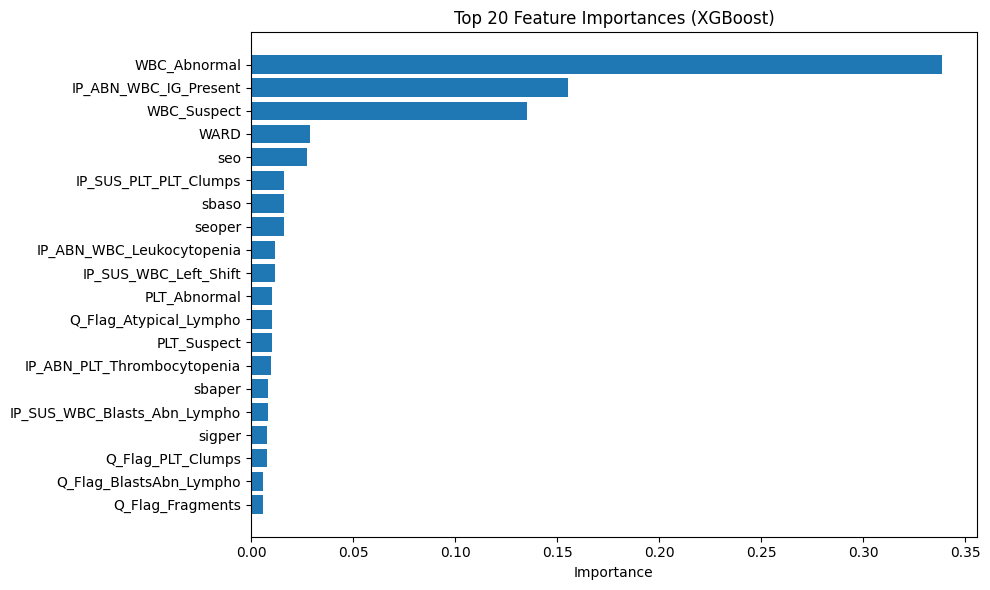

In [4]:
# ==== XGBOOST with Recall-First Threshold (choose HIGHEST threshold meeting target) ====
# - Uses explicit numeric/binary columns
# - Cleans column names to safe identifiers
# - 80:20 split with stratify
# - Handles imbalance via scale_pos_weight
# - Picks the HIGHEST threshold with recall >= TARGET_RECALL (reduces FP flood)
# - Prints metrics at chosen threshold + 95% Wilson CIs + PR-AUC/ROC-AUC
# - Plots top features

import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from difflib import get_close_matches
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, precision_score, recall_score
)

from xgboost import XGBClassifier

# ========= 1) SETTINGS =========
file_path  = r"C:\Users\Peempol\ML_Autover\Ex1\completeclean.csv"
target_col = "anyflag"

numeric_cols = [
    'age','Q_Flag_BlastsAbn_Lympho','Q_Flag_Blasts','Q_Flag_AbnLympho',
    'Q_Flag_LeftShift','Q_Flag_Atypical_Lympho','Q_Flag_RBC_Agglutination',
    'Q_Flag_TurbidityHGBInterf','Q_Flag_Iron_Deficiency','Q_FlagHGB_Defect',
    'Q_Flag_Fragments','Q_Flag_PLT_Clumps','swbc','srbc','shgb','shct',
    'smcv','smch','smchc','splt','srdw','srdw_1','spdw','smpv','slcr','spct',
    'snrbc','snrbcpercent','sn','sl','smo','seo','sbaso','snper','slper',
    'smoper','seoper','sbaper','sig','sigper','splti','MicroR','MacroR',
    'tnc','ba_n','ba_n_per','wbc_D','tnc_D','NEUT_1','NEUTpercent',
    'LYMP','LYMPper','HFLC','HFLCper','BA_D','BA_D_1','NE_SSC','NE_SFL',
    'NE_FSC','LY_X','LY_Y','LY_Z','MO_X','MO_Y','MO_Z','NE_WX','NE_WY',
    'NE_WZ','LY_WX','LY_WY','LY_WZ','MO_WX','MO_WY','MO_WZ'
]

binary_cols = [
    'sex','WARD','WBC_Abnormal','WBC_Suspect','RBC_Abnormal','RBC_Suspect',
    'PLT_Abnormal','PLT_Suspect','IP_ABN_WBC_Abn_Scattergram',
    'IP_ABN_WBC_Neutropenia','IP_ABN_WBC_Neutrophilia',
    'IP_ABN_WBC_Lymphopenia','IP_ABN_WBC_Lymphocytosis',
    'IP_ABN_WBC_Monocytosis','IP_ABN_WBC_Eosinophilia','IP_ABN_WBC_Basophilia',
    'IP_ABN_WBC_Leukocytopenia','IP_ABN_WBC_Leukocytosis',
    'IP_ABN_WBC_NRBC_Present','IP_ABN_WBC_IG_Present',
    'IP_ABN_RBC_RBC_Abn_Distribution','IP_ABN_RBC_Dimorphic_Population',
    'IP_ABN_RBC_Anisocytosis','IP_ABN_RBC_Microcytosis','IP_ABN_RBC_Macrocytosis',
    'IP_ABN_RBC_Hypochromia','IP_ABN_RBC_Anemia','IP_ABN_RBC_Erythrocytosis',
    'IP_ABN_RBC_RET_Abn_Scattergram','IP_ABN_RBC_Reticulocytosis',
    'IP_ABN_PLT_PLT_Abn_Distribution','IP_ABN_PLT_Thrombocytopenia',
    'IP_ABN_PLT_Thrombocytosis','IP_ABN_PLT_PLT_Abn_Scattergram',
    'IP_SUS_WBC_Blasts_Abn_Lympho','IP_SUS_WBC_Blasts',
    'IP_SUS_WBC_Abn_Lympho','IP_SUS_WBC_Left_Shift',
    'IP_SUS_WBC_Atypical_Lympho','IP_SUS_RBC_RBC_Agglutination',
    'IP_SUS_RBC_Turbidity_HGB_Interf','IP_SUS_RBC_Iron_Deficiency',
    'IP_SUS_RBC_HGB_Defect','IP_SUS_RBC_Fragments','IP_SUS_PLT_PLT_Clumps'
]

test_size      = 0.20
random_seed    = 42
top_k_features = 20

# IMPORTANT: set TARGET_RECALL to 0.95 and rerun; then set to 0.975 and rerun
TARGET_RECALL  = 0.95

# ========= 2) HELPERS =========
def clean_colname(col: str) -> str:
    col = (col
           .replace(" NRBC Present", "_NRBC_Present")
           .replace(" IG Present", "_IG_Present")
           .replace(" Dimorphic Population", "_Dimorphic_Population")
           .replace(" Atypical Lympho", "_Atypical_Lympho")
           .replace(" Turbidity_HGB Interf", "_Turbidity_HGB_Interf"))
    col = re.sub(r'[^0-9a-zA-Z_]', '_', col)
    col = re.sub(r'__+', '_', col).strip('_')
    return col

def to_binary(series: pd.Series) -> pd.Series:
    mapping = {
        "1":1,"0":0,"yes":1,"no":0,"true":1,"false":0,"y":1,"n":0,
        "present":1,"absent":0,"pos":1,"neg":0,"positive":1,"negative":0,
        "abnormal":1,"normal":0,"clumps":1,"no_clumps":0
    }
    s = series.astype(str).str.lower().str.strip().map(mapping)
    if s.isna().any():
        num = pd.to_numeric(series, errors="coerce")
        s = s.where(~num.notna(), (num.fillna(0) != 0).astype(int))
    return s.fillna(0).astype(int)

def wilson_ci(k: int, n: int, alpha: float = 0.05):
    """95% Wilson score interval for a binomial proportion."""
    if n <= 0:
        return (float("nan"), float("nan"))
    z = 1.959963984540054  # 95%
    p = k / n
    denom = 1 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = (z * math.sqrt((p*(1-p) + (z**2)/(4*n)) / n)) / denom
    return (center - half, center + half)

def approx_halfwidth(p: float, n: int):
    """Approx 95% CI half-width for planning."""
    if n <= 0:
        return float("nan")
    z = 1.959963984540054
    return z * math.sqrt(p*(1-p)/n)

def metrics_with_cis(y_true: np.ndarray, y_pred: np.ndarray):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    n_pos = tp + fn
    n_neg = tn + fp

    recall = tp / n_pos if n_pos else float("nan")
    spec   = tn / n_neg if n_neg else float("nan")
    ppv    = tp / (tp + fp) if (tp + fp) else float("nan")
    npv    = tn / (tn + fn) if (tn + fn) else float("nan")

    return {
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "n_total": int(len(y_true)), "n_pos": int(n_pos), "n_neg": int(n_neg),
        "recall": recall, "recall_ci": wilson_ci(tp, n_pos),
        "specificity": spec, "specificity_ci": wilson_ci(tn, n_neg),
        "ppv": ppv, "ppv_ci": wilson_ci(tp, tp + fp) if (tp + fp) else (float("nan"), float("nan")),
        "npv": npv, "npv_ci": wilson_ci(tn, tn + fn) if (tn + fn) else (float("nan"), float("nan")),
    }

# ========= 3) LOAD & CLEAN COLUMN NAMES =========
df = pd.read_csv(file_path, low_memory=False)
df.columns = [clean_colname(c) for c in df.columns]

# ========= 4) VALIDATE REQUESTED COLUMNS =========
want_cols = numeric_cols + binary_cols + [target_col]
missing = [c for c in want_cols if c not in df.columns]
if missing:
    print("\n[WARN] Columns not found after cleaning. Adjust lists or cleaner:")
    for m in missing:
        sug = get_close_matches(m, df.columns.tolist(), n=1, cutoff=0.7)
        print(f"  - {m}" + (f"  (closest: {sug[0]})" if sug else ""))

avail_numeric = [c for c in numeric_cols if c in df.columns]
avail_binary  = [c for c in binary_cols  if c in df.columns]

if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found. Available: {df.columns.tolist()}")

# ========= 5) TYPE COERCION =========
for c in avail_numeric:
    df[c] = pd.to_numeric(df[c], errors="coerce")

for c in avail_binary:
    df[c] = to_binary(df[c])

df = df[~df[target_col].isna()].copy()

y = df[target_col]
if not np.issubdtype(y.dtype, np.number):
    y = y.astype("category").cat.codes
y = np.asarray(y)

X = df[avail_numeric + avail_binary].fillna(0)

# Drop constant columns
const_cols = X.columns[X.nunique() <= 1].tolist()
if const_cols:
    X = X.drop(columns=const_cols)

# ========= 6) SPLIT =========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_seed, stratify=y
)

# ========= 7) XGB MODEL =========
n_classes = int(len(np.unique(y_train)))
if n_classes != 2:
    raise ValueError(f"Expected binary target, but got {n_classes} classes.")

pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw = float(neg) / max(1.0, float(pos))

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    max_delta_step=1,
    tree_method="hist",
    n_jobs=-1,
    random_state=random_seed,
    scale_pos_weight=spw
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# ========= 8) THRESHOLD TUNING (Highest threshold with recall >= target) =========
y_proba = xgb.predict_proba(X_test)[:, 1]

thr_candidates = np.unique(np.r_[0.0, np.round(y_proba, 6), 1.0])

rows = []
for thr in thr_candidates:
    y_hat = (y_proba >= thr).astype(int)
    prec = precision_score(y_test, y_hat, zero_division=0)
    rec  = recall_score(y_test, y_hat, zero_division=0)
    fn   = int(((y_test == 1) & (y_hat == 0)).sum())
    fp   = int(((y_test == 0) & (y_hat == 1)).sum())
    rows.append((thr, prec, rec, fn, fp))

thr_df = pd.DataFrame(rows, columns=["threshold","precision","recall","FN","FP"])

meets = thr_df[thr_df["recall"] >= TARGET_RECALL]
if len(meets):
    # Choose the HIGHEST threshold that still meets recall (reduces FP flood)
    best_row = meets.sort_values(by=["threshold"], ascending=[False]).iloc[0]
else:
    # If target recall not achievable: maximize recall, then maximize threshold
    best_row = thr_df.sort_values(by=["recall","threshold"], ascending=[False, False]).iloc[0]

BEST_THR = float(best_row["threshold"])
print(f"\nChosen threshold = {BEST_THR:.6f} | recall={best_row['recall']:.4f} "
      f"| precision={best_row['precision']:.4f} | FN={best_row['FN']} | FP={best_row['FP']}")

y_pred_thr = (y_proba >= BEST_THR).astype(int)

print("\n=== Report @ chosen threshold (recall-first, highest threshold) ===")
print(classification_report(y_test, y_pred_thr, digits=4))
print("Confusion matrix @ chosen threshold:")
print(confusion_matrix(y_test, y_pred_thr))

# ========= 9) METRICS + 95% Wilson CIs =========
m = metrics_with_cis(y_test, y_pred_thr)

print("\n=== Metrics with 95% Wilson CIs ===")
print(f"Test set: N={m['n_total']} | positives={m['n_pos']} | negatives={m['n_neg']}")
print(f"Recall/Sensitivity = {m['recall']:.4f} (95% CI {m['recall_ci'][0]:.4f}–{m['recall_ci'][1]:.4f})")
print(f"Specificity         = {m['specificity']:.4f} (95% CI {m['specificity_ci'][0]:.4f}–{m['specificity_ci'][1]:.4f})")
print(f"PPV                 = {m['ppv']:.4f} (95% CI {m['ppv_ci'][0]:.4f}–{m['ppv_ci'][1]:.4f})")
print(f"NPV                 = {m['npv']:.4f} (95% CI {m['npv_ci'][0]:.4f}–{m['npv_ci'][1]:.4f})")

# Adequacy / precision of recall estimate depends on number of positives
hw_if_95  = approx_halfwidth(0.95,  m["n_pos"])
hw_if_975 = approx_halfwidth(0.975, m["n_pos"])
print("\n=== Recall precision (approx; depends on #positives in test set) ===")
print(f"Approx 95% CI half-width if true recall=0.95  : ±{hw_if_95:.4f}")
print(f"Approx 95% CI half-width if true recall=0.975 : ±{hw_if_975:.4f}")

# ========= 10) ROC-AUC + PR-AUC (robust integration) =========
try:
    roc = roc_auc_score(y_test, y_proba)
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
    order = np.argsort(rec_curve)
    pr_auc = np.trapz(prec_curve[order], rec_curve[order])
    print(f"\nROC-AUC={roc:.4f} | PR-AUC≈{pr_auc:.4f}")
except Exception as e:
    print(f"\n[WARN] Could not compute ROC/PR AUC: {e}")

# ========= 11) FEATURE IMPORTANCE PLOT =========
importances = xgb.feature_importances_
imp = (pd.DataFrame({"Feature": X.columns, "Importance": importances})
       .sort_values("Importance", ascending=False)
       .reset_index(drop=True))

print("\nTop features:")
print(imp.head(top_k_features))

plt.figure(figsize=(10, 6))
top = imp.head(top_k_features)[::-1]
plt.barh(top["Feature"], top["Importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_k_features} Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

# ========= 12) DEPLOYMENT HINT =========
# probs = xgb.predict_proba(X_new)[:, 1]
# preds = (probs >= BEST_THR).astype(int)   # use BEST_THR chosen above



Chosen threshold = 0.088398 | recall=0.9752 | precision=0.5842 | FN=97.0 | FP=2712.0

=== Report @ chosen threshold (recall-first, highest threshold) ===
              precision    recall  f1-score   support

         0.0     0.9841    0.6895    0.8109      8733
         1.0     0.5842    0.9752    0.7307      3908

    accuracy                         0.7778     12641
   macro avg     0.7842    0.8323    0.7708     12641
weighted avg     0.8605    0.7778    0.7861     12641

Confusion matrix @ chosen threshold:
[[6021 2712]
 [  97 3811]]

=== Metrics with 95% Wilson CIs ===
Test set: N=12641 | positives=3908 | negatives=8733
Recall/Sensitivity = 0.9752 (95% CI 0.9698–0.9796)
Specificity         = 0.6895 (95% CI 0.6797–0.6991)
PPV                 = 0.5842 (95% CI 0.5722–0.5961)
NPV                 = 0.9841 (95% CI 0.9807–0.9870)

=== Recall precision (approx; depends on #positives in test set) ===
Approx 95% CI half-width if true recall=0.95  : ±0.0068
Approx 95% CI half-width if true

C:\Users\Peempol\AppData\Local\Temp\ipykernel_18660\403791052.py:268: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc = np.trapz(prec_curve[order], rec_curve[order])


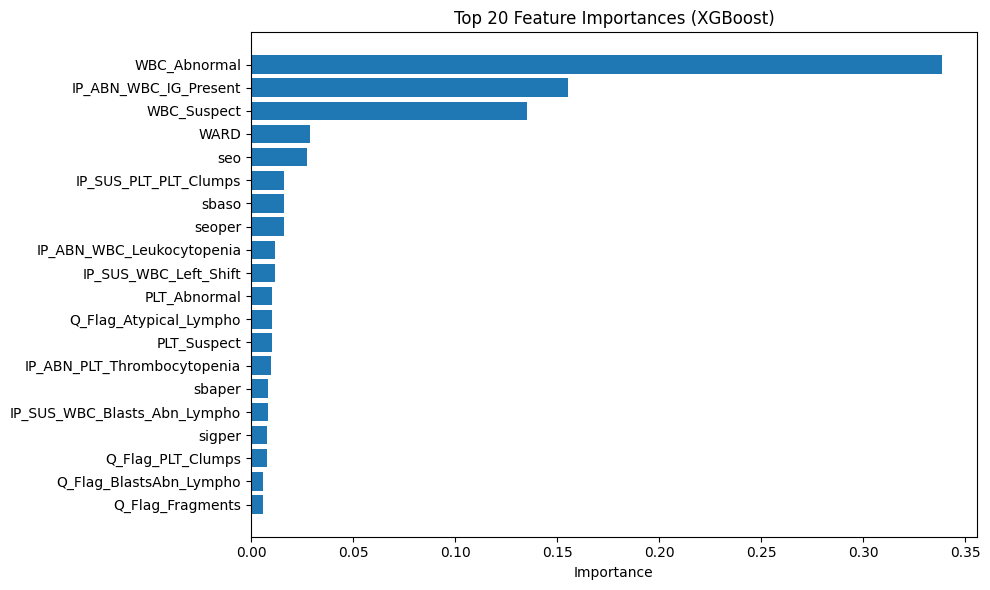

In [5]:
# ==== XGBOOST with Recall-First Threshold (choose HIGHEST threshold meeting target) ====
# - Uses explicit numeric/binary columns
# - Cleans column names to safe identifiers
# - 80:20 split with stratify
# - Handles imbalance via scale_pos_weight
# - Picks the HIGHEST threshold with recall >= TARGET_RECALL (reduces FP flood)
# - Prints metrics at chosen threshold + 95% Wilson CIs + PR-AUC/ROC-AUC
# - Plots top features

import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from difflib import get_close_matches
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, precision_score, recall_score
)

from xgboost import XGBClassifier

# ========= 1) SETTINGS =========
file_path  = r"C:\Users\Peempol\ML_Autover\Ex1\completeclean.csv"
target_col = "anyflag"

numeric_cols = [
    'age','Q_Flag_BlastsAbn_Lympho','Q_Flag_Blasts','Q_Flag_AbnLympho',
    'Q_Flag_LeftShift','Q_Flag_Atypical_Lympho','Q_Flag_RBC_Agglutination',
    'Q_Flag_TurbidityHGBInterf','Q_Flag_Iron_Deficiency','Q_FlagHGB_Defect',
    'Q_Flag_Fragments','Q_Flag_PLT_Clumps','swbc','srbc','shgb','shct',
    'smcv','smch','smchc','splt','srdw','srdw_1','spdw','smpv','slcr','spct',
    'snrbc','snrbcpercent','sn','sl','smo','seo','sbaso','snper','slper',
    'smoper','seoper','sbaper','sig','sigper','splti','MicroR','MacroR',
    'tnc','ba_n','ba_n_per','wbc_D','tnc_D','NEUT_1','NEUTpercent',
    'LYMP','LYMPper','HFLC','HFLCper','BA_D','BA_D_1','NE_SSC','NE_SFL',
    'NE_FSC','LY_X','LY_Y','LY_Z','MO_X','MO_Y','MO_Z','NE_WX','NE_WY',
    'NE_WZ','LY_WX','LY_WY','LY_WZ','MO_WX','MO_WY','MO_WZ'
]

binary_cols = [
    'sex','WARD','WBC_Abnormal','WBC_Suspect','RBC_Abnormal','RBC_Suspect',
    'PLT_Abnormal','PLT_Suspect','IP_ABN_WBC_Abn_Scattergram',
    'IP_ABN_WBC_Neutropenia','IP_ABN_WBC_Neutrophilia',
    'IP_ABN_WBC_Lymphopenia','IP_ABN_WBC_Lymphocytosis',
    'IP_ABN_WBC_Monocytosis','IP_ABN_WBC_Eosinophilia','IP_ABN_WBC_Basophilia',
    'IP_ABN_WBC_Leukocytopenia','IP_ABN_WBC_Leukocytosis',
    'IP_ABN_WBC_NRBC_Present','IP_ABN_WBC_IG_Present',
    'IP_ABN_RBC_RBC_Abn_Distribution','IP_ABN_RBC_Dimorphic_Population',
    'IP_ABN_RBC_Anisocytosis','IP_ABN_RBC_Microcytosis','IP_ABN_RBC_Macrocytosis',
    'IP_ABN_RBC_Hypochromia','IP_ABN_RBC_Anemia','IP_ABN_RBC_Erythrocytosis',
    'IP_ABN_RBC_RET_Abn_Scattergram','IP_ABN_RBC_Reticulocytosis',
    'IP_ABN_PLT_PLT_Abn_Distribution','IP_ABN_PLT_Thrombocytopenia',
    'IP_ABN_PLT_Thrombocytosis','IP_ABN_PLT_PLT_Abn_Scattergram',
    'IP_SUS_WBC_Blasts_Abn_Lympho','IP_SUS_WBC_Blasts',
    'IP_SUS_WBC_Abn_Lympho','IP_SUS_WBC_Left_Shift',
    'IP_SUS_WBC_Atypical_Lympho','IP_SUS_RBC_RBC_Agglutination',
    'IP_SUS_RBC_Turbidity_HGB_Interf','IP_SUS_RBC_Iron_Deficiency',
    'IP_SUS_RBC_HGB_Defect','IP_SUS_RBC_Fragments','IP_SUS_PLT_PLT_Clumps'
]

test_size      = 0.20
random_seed    = 42
top_k_features = 20

# IMPORTANT: set TARGET_RECALL to 0.95 and rerun; then set to 0.975 and rerun
TARGET_RECALL  = 0.975

# ========= 2) HELPERS =========
def clean_colname(col: str) -> str:
    col = (col
           .replace(" NRBC Present", "_NRBC_Present")
           .replace(" IG Present", "_IG_Present")
           .replace(" Dimorphic Population", "_Dimorphic_Population")
           .replace(" Atypical Lympho", "_Atypical_Lympho")
           .replace(" Turbidity_HGB Interf", "_Turbidity_HGB_Interf"))
    col = re.sub(r'[^0-9a-zA-Z_]', '_', col)
    col = re.sub(r'__+', '_', col).strip('_')
    return col

def to_binary(series: pd.Series) -> pd.Series:
    mapping = {
        "1":1,"0":0,"yes":1,"no":0,"true":1,"false":0,"y":1,"n":0,
        "present":1,"absent":0,"pos":1,"neg":0,"positive":1,"negative":0,
        "abnormal":1,"normal":0,"clumps":1,"no_clumps":0
    }
    s = series.astype(str).str.lower().str.strip().map(mapping)
    if s.isna().any():
        num = pd.to_numeric(series, errors="coerce")
        s = s.where(~num.notna(), (num.fillna(0) != 0).astype(int))
    return s.fillna(0).astype(int)

def wilson_ci(k: int, n: int, alpha: float = 0.05):
    """95% Wilson score interval for a binomial proportion."""
    if n <= 0:
        return (float("nan"), float("nan"))
    z = 1.959963984540054  # 95%
    p = k / n
    denom = 1 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = (z * math.sqrt((p*(1-p) + (z**2)/(4*n)) / n)) / denom
    return (center - half, center + half)

def approx_halfwidth(p: float, n: int):
    """Approx 95% CI half-width for planning."""
    if n <= 0:
        return float("nan")
    z = 1.959963984540054
    return z * math.sqrt(p*(1-p)/n)

def metrics_with_cis(y_true: np.ndarray, y_pred: np.ndarray):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    n_pos = tp + fn
    n_neg = tn + fp

    recall = tp / n_pos if n_pos else float("nan")
    spec   = tn / n_neg if n_neg else float("nan")
    ppv    = tp / (tp + fp) if (tp + fp) else float("nan")
    npv    = tn / (tn + fn) if (tn + fn) else float("nan")

    return {
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "n_total": int(len(y_true)), "n_pos": int(n_pos), "n_neg": int(n_neg),
        "recall": recall, "recall_ci": wilson_ci(tp, n_pos),
        "specificity": spec, "specificity_ci": wilson_ci(tn, n_neg),
        "ppv": ppv, "ppv_ci": wilson_ci(tp, tp + fp) if (tp + fp) else (float("nan"), float("nan")),
        "npv": npv, "npv_ci": wilson_ci(tn, tn + fn) if (tn + fn) else (float("nan"), float("nan")),
    }

# ========= 3) LOAD & CLEAN COLUMN NAMES =========
df = pd.read_csv(file_path, low_memory=False)
df.columns = [clean_colname(c) for c in df.columns]

# ========= 4) VALIDATE REQUESTED COLUMNS =========
want_cols = numeric_cols + binary_cols + [target_col]
missing = [c for c in want_cols if c not in df.columns]
if missing:
    print("\n[WARN] Columns not found after cleaning. Adjust lists or cleaner:")
    for m in missing:
        sug = get_close_matches(m, df.columns.tolist(), n=1, cutoff=0.7)
        print(f"  - {m}" + (f"  (closest: {sug[0]})" if sug else ""))

avail_numeric = [c for c in numeric_cols if c in df.columns]
avail_binary  = [c for c in binary_cols  if c in df.columns]

if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found. Available: {df.columns.tolist()}")

# ========= 5) TYPE COERCION =========
for c in avail_numeric:
    df[c] = pd.to_numeric(df[c], errors="coerce")

for c in avail_binary:
    df[c] = to_binary(df[c])

df = df[~df[target_col].isna()].copy()

y = df[target_col]
if not np.issubdtype(y.dtype, np.number):
    y = y.astype("category").cat.codes
y = np.asarray(y)

X = df[avail_numeric + avail_binary].fillna(0)

# Drop constant columns
const_cols = X.columns[X.nunique() <= 1].tolist()
if const_cols:
    X = X.drop(columns=const_cols)

# ========= 6) SPLIT =========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_seed, stratify=y
)

# ========= 7) XGB MODEL =========
n_classes = int(len(np.unique(y_train)))
if n_classes != 2:
    raise ValueError(f"Expected binary target, but got {n_classes} classes.")

pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw = float(neg) / max(1.0, float(pos))

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    max_delta_step=1,
    tree_method="hist",
    n_jobs=-1,
    random_state=random_seed,
    scale_pos_weight=spw
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# ========= 8) THRESHOLD TUNING (Highest threshold with recall >= target) =========
y_proba = xgb.predict_proba(X_test)[:, 1]

thr_candidates = np.unique(np.r_[0.0, np.round(y_proba, 6), 1.0])

rows = []
for thr in thr_candidates:
    y_hat = (y_proba >= thr).astype(int)
    prec = precision_score(y_test, y_hat, zero_division=0)
    rec  = recall_score(y_test, y_hat, zero_division=0)
    fn   = int(((y_test == 1) & (y_hat == 0)).sum())
    fp   = int(((y_test == 0) & (y_hat == 1)).sum())
    rows.append((thr, prec, rec, fn, fp))

thr_df = pd.DataFrame(rows, columns=["threshold","precision","recall","FN","FP"])

meets = thr_df[thr_df["recall"] >= TARGET_RECALL]
if len(meets):
    # Choose the HIGHEST threshold that still meets recall (reduces FP flood)
    best_row = meets.sort_values(by=["threshold"], ascending=[False]).iloc[0]
else:
    # If target recall not achievable: maximize recall, then maximize threshold
    best_row = thr_df.sort_values(by=["recall","threshold"], ascending=[False, False]).iloc[0]

BEST_THR = float(best_row["threshold"])
print(f"\nChosen threshold = {BEST_THR:.6f} | recall={best_row['recall']:.4f} "
      f"| precision={best_row['precision']:.4f} | FN={best_row['FN']} | FP={best_row['FP']}")

y_pred_thr = (y_proba >= BEST_THR).astype(int)

print("\n=== Report @ chosen threshold (recall-first, highest threshold) ===")
print(classification_report(y_test, y_pred_thr, digits=4))
print("Confusion matrix @ chosen threshold:")
print(confusion_matrix(y_test, y_pred_thr))

# ========= 9) METRICS + 95% Wilson CIs =========
m = metrics_with_cis(y_test, y_pred_thr)

print("\n=== Metrics with 95% Wilson CIs ===")
print(f"Test set: N={m['n_total']} | positives={m['n_pos']} | negatives={m['n_neg']}")
print(f"Recall/Sensitivity = {m['recall']:.4f} (95% CI {m['recall_ci'][0]:.4f}–{m['recall_ci'][1]:.4f})")
print(f"Specificity         = {m['specificity']:.4f} (95% CI {m['specificity_ci'][0]:.4f}–{m['specificity_ci'][1]:.4f})")
print(f"PPV                 = {m['ppv']:.4f} (95% CI {m['ppv_ci'][0]:.4f}–{m['ppv_ci'][1]:.4f})")
print(f"NPV                 = {m['npv']:.4f} (95% CI {m['npv_ci'][0]:.4f}–{m['npv_ci'][1]:.4f})")

# Adequacy / precision of recall estimate depends on number of positives
hw_if_95  = approx_halfwidth(0.95,  m["n_pos"])
hw_if_975 = approx_halfwidth(0.975, m["n_pos"])
print("\n=== Recall precision (approx; depends on #positives in test set) ===")
print(f"Approx 95% CI half-width if true recall=0.95  : ±{hw_if_95:.4f}")
print(f"Approx 95% CI half-width if true recall=0.975 : ±{hw_if_975:.4f}")

# ========= 10) ROC-AUC + PR-AUC (robust integration) =========
try:
    roc = roc_auc_score(y_test, y_proba)
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
    order = np.argsort(rec_curve)
    pr_auc = np.trapz(prec_curve[order], rec_curve[order])
    print(f"\nROC-AUC={roc:.4f} | PR-AUC≈{pr_auc:.4f}")
except Exception as e:
    print(f"\n[WARN] Could not compute ROC/PR AUC: {e}")

# ========= 11) FEATURE IMPORTANCE PLOT =========
importances = xgb.feature_importances_
imp = (pd.DataFrame({"Feature": X.columns, "Importance": importances})
       .sort_values("Importance", ascending=False)
       .reset_index(drop=True))

print("\nTop features:")
print(imp.head(top_k_features))

plt.figure(figsize=(10, 6))
top = imp.head(top_k_features)[::-1]
plt.barh(top["Feature"], top["Importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_k_features} Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

# ========= 12) DEPLOYMENT HINT =========
# probs = xgb.predict_proba(X_new)[:, 1]
# preds = (probs >= BEST_THR).astype(int)   # use BEST_THR chosen above
